In [1]:
from mindquantum.core import Circuit, Hamiltonian, UN, H, ZZ, RX, QubitOperator
from mindquantum.framework import MQAnsatzOnlyLayer
from mindquantum.simulator import Simulator
import networkx as nx
import mindspore.nn as nn

one size: [0] cut= 3
one size: [1] cut= 3
one: [1, 0] cut= 4
one size: [2] cut= 3
one: [2, 0] cut= 4
one: [2, 1] cut= 6
one size: [3] cut= 2
one: [3, 0] cut= 5
one: [3, 1] cut= 3
one: [3, 2] cut= 5
one size: [4] cut= 3
one: [4, 0] cut= 6
one: [4, 1] cut= 6
one: [4, 2] cut= 4
one: [4, 3] cut= 5
one size: [5] cut= 4
one: [5, 0] cut= 7
one: [5, 1] cut= 5
one: [5, 2] cut= 7
one: [5, 3] cut= 6
one: [5, 4] cut= 5
one size: [7] cut= 3
one: [7, 0] cut= 6
one: [7, 1] cut= 6
one: [7, 2] cut= 6
one: [7, 3] cut= 3
one: [7, 4] cut= 4
one: [7, 5] cut= 5
one: [7, 6] cut= 6
one size: [6] cut= 3
one: [6, 0] cut= 4
one: [6, 1] cut= 6
one: [6, 2] cut= 4
one: [6, 3] cut= 5
one: [6, 4] cut= 6
one: [6, 5] cut= 5


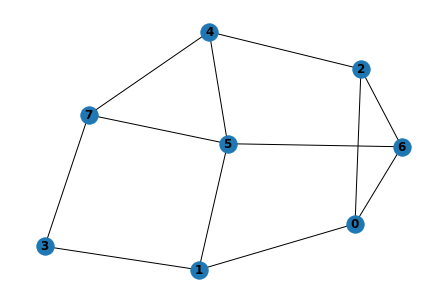

In [2]:
g = nx.Graph()
nx.add_path(g, [0,1])
nx.add_path(g, [0,2])
nx.add_path(g, [1,3])
nx.add_path(g, [2,4])
nx.add_path(g, [4,5])
nx.add_path(g, [4,7])
nx.add_path(g, [5,6])
nx.add_path(g, [6,2])
nx.add_path(g, [7,4])
nx.add_path(g, [1,5])
nx.add_path(g, [0,6])
nx.add_path(g, [5,7])
nx.add_path(g, [7,3])
nx.draw(g, with_labels=True, font_weight='bold')

for i in g.nodes:
   print('one size:', [i], 'cut=', nx.cut_size(g, [i]))
   for j in range(i):
      print('one:', [i, j], 'cut=', nx.cut_size(g, [i, j]))

In [10]:
def build_hc(g, para):
    hc = Circuit()
    for i in g.edges:
        hc += ZZ(para).on(i)
    hc.barrier()
    return hc
    
circuit = build_hc(g, 'gamma')
circuit.svg()

In [25]:
def build_hb(g, para):
    hb = Circuit()
    for i in g.nodes:
        hb += RX(para).on(i)
    hb.barrier()
    return hb
circuit = build_hb(g, 'beta')
circuit.svg()

In [26]:
circuit = build_hc(g, 'gamma') + build_hb(g, 'beta')
circuit.svg()

In [46]:
def build_ansatz(g, p):
    circ = Circuit()
    for i in range(p):
        circ +=  build_hc(g, f'g{i}')
        circ += build_hc(g, f'g{i}')
        circ += build_hb(g, f'b{i}')
    return circ
def build_ham(g):
    ham = QubitOperator()
    for i in g.edges:
        ham += QubitOperator(f'Z{i[0]} Z{i[1]}')
    return ham

p = 7
ham = Hamiltonian(build_ham(g))
init_state_circ = UN(H, g.nodes)
ansatz = build_ansatz(g, p)
circ = init_state_circ + ansatz
circ.svg()

In [52]:
import mindspore as ms
ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU")

sim = Simulator('projectq', circ.n_qubits)
grad_ops = sim.get_expectation_with_grad(ham, circ)
net = MQAnsatzOnlyLayer(grad_ops)
opti = nn.Adam(net.trainable_params(), learning_rate=0.05)
train_net = nn.TrainOneStepCell(net, opti)

In [59]:
for i in range(200):
    cut = (len(g.edges) - train_net()) / 2
    if i%10 == 0:
        print("train step:", i, ", cut:", cut)

[WARNING] DEBUG(18139,7fec1094d740,python):2022-06-18-14:03:26.213.403 [mindspore/ccsrc/debug/debugger/debugger.cc:95] Debugger] Not enabling debugger. Debugger does not support CPU.
train step: 0 , cut: [5.9991784]
train step: 10 , cut: [8.683768]
train step: 20 , cut: [9.103767]
train step: 30 , cut: [9.350706]
train step: 40 , cut: [9.401057]
train step: 50 , cut: [9.4375]
train step: 60 , cut: [9.443407]
train step: 70 , cut: [9.448747]
train step: 80 , cut: [9.450784]
train step: 90 , cut: [9.45207]
train step: 100 , cut: [9.453114]
train step: 110 , cut: [9.4130945]
train step: 120 , cut: [9.43578]
train step: 130 , cut: [9.453804]
train step: 140 , cut: [9.453956]
train step: 150 , cut: [9.454689]
train step: 160 , cut: [9.455864]
train step: 170 , cut: [9.456181]
train step: 180 , cut: [9.456638]
train step: 190 , cut: [9.457024]


In [60]:
pr = dict(zip(ansatz.params_name, net.weight.asnumpy()))
print(pr)

{'g0': -0.055120606, 'b0': 0.3246892, 'g1': -0.16756378, 'b1': -0.1460366, 'g2': 0.41623384, 'b2': -0.041699868, 'g3': 0.04823855, 'b3': -0.080118425, 'g4': -0.38012174, 'b4': 0.94459105, 'g5': -0.1863419, 'b5': 0.66669434, 'g6': -0.23498039, 'b6': 0.36173126}


In [62]:
circ.measure_all()
sim.sampling(circ, pr=pr, shots=1000).svg()